У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Завантаження даних з файлу train.csv.zip
df = pd.read_csv("train.csv.zip")

# Перетворення колонки date у формат datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Встановлення колонки date як індекс
df.set_index("date", inplace=True)

# Виведення перших 10 рядків
display(df.head(10))

# Виведення інформації про датафрейм
df.info()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



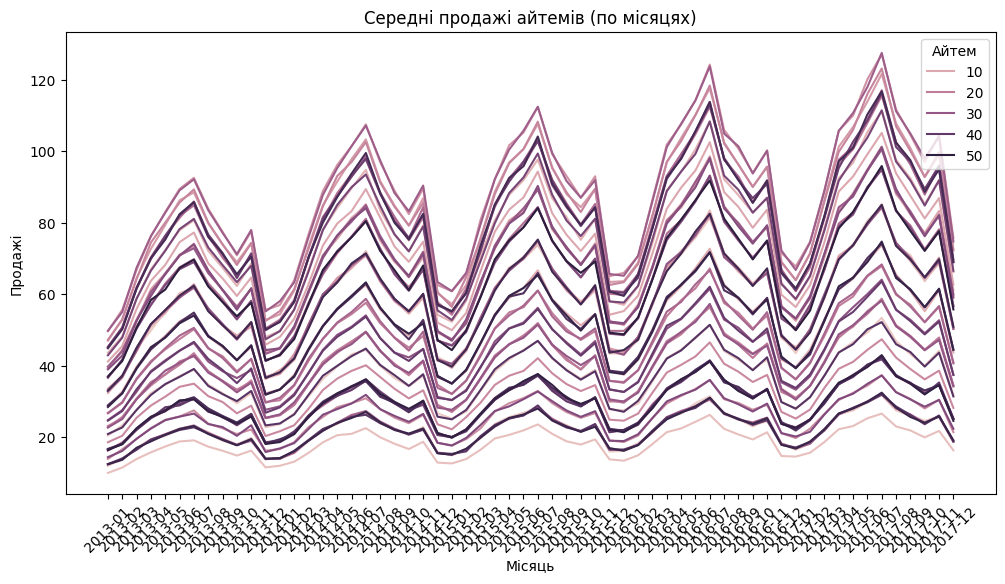

In [12]:
# Додавання колонки місяць для агрегації
df["month"] = df.index.to_period("M").astype(str)

# Візуалізація 1: Середні продажі по айтемах  (по місяцях)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.groupby(["month", "item"]).agg({"sales": "mean"}).reset_index(), 
             x="month", y="sales", hue="item", errorbar='sd')
plt.title("Середні продажі айтемів (по місяцях)")
plt.xlabel("Місяць")
plt.ylabel("Продажі")
plt.xticks(rotation=45)
plt.legend(title="Айтем", loc='upper right')
plt.show()

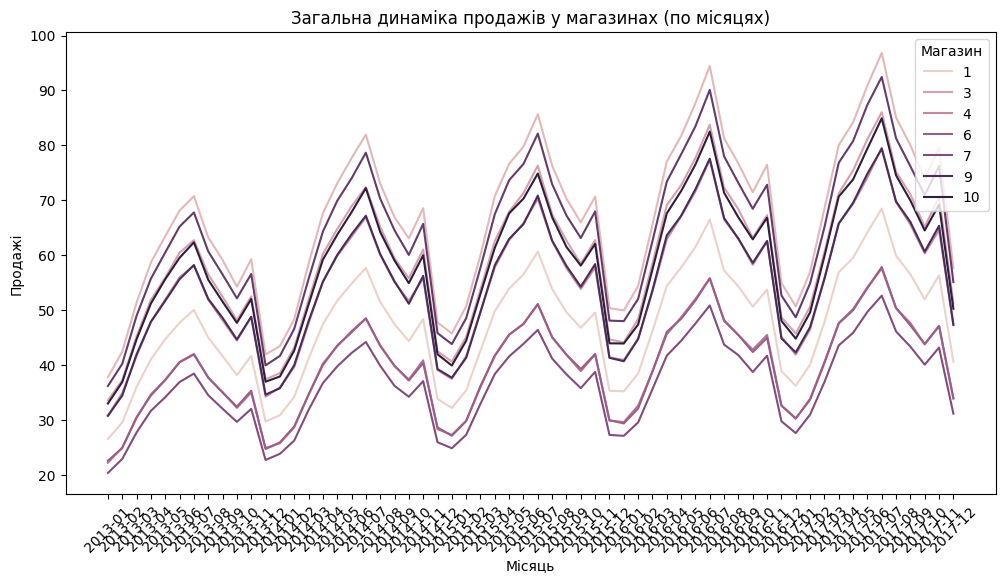

In [9]:
# Візуалізація 2: Загальна динаміка продажів по магазинах (по місяцях)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.groupby(["month", "store"]).agg({"sales": "mean"}).reset_index(), 
             x="month", y="sales", hue="store", errorbar=None)
plt.title("Загальна динаміка продажів у магазинах (по місяцях)")
plt.xlabel("Місяць")
plt.ylabel("Продажі")
plt.xticks(rotation=45)
plt.legend(title="Магазин", loc='upper right')
plt.show()

## Висновки
На основі графіка середніх продажів айтемів по місяцях можна зробити такі висновки:
    
    1.	Яскраво виражена сезонність – спостерігаються регулярні піки продажів, які повторюються з певною періодичністю. Це може вказувати на певні маркетингові кампанії, сезонні акції або святкові періоди.
	2.	Спад між піками – після кожного зростання відбувається падіння продажів, що може означати закінчення акцій або періодів підвищеного попиту.
	3.	Зростаюча динаміка в цілому – з часом середні продажі збільшуються, що може свідчити про загальне зростання попиту на айтеми або розширення клієнтської бази.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

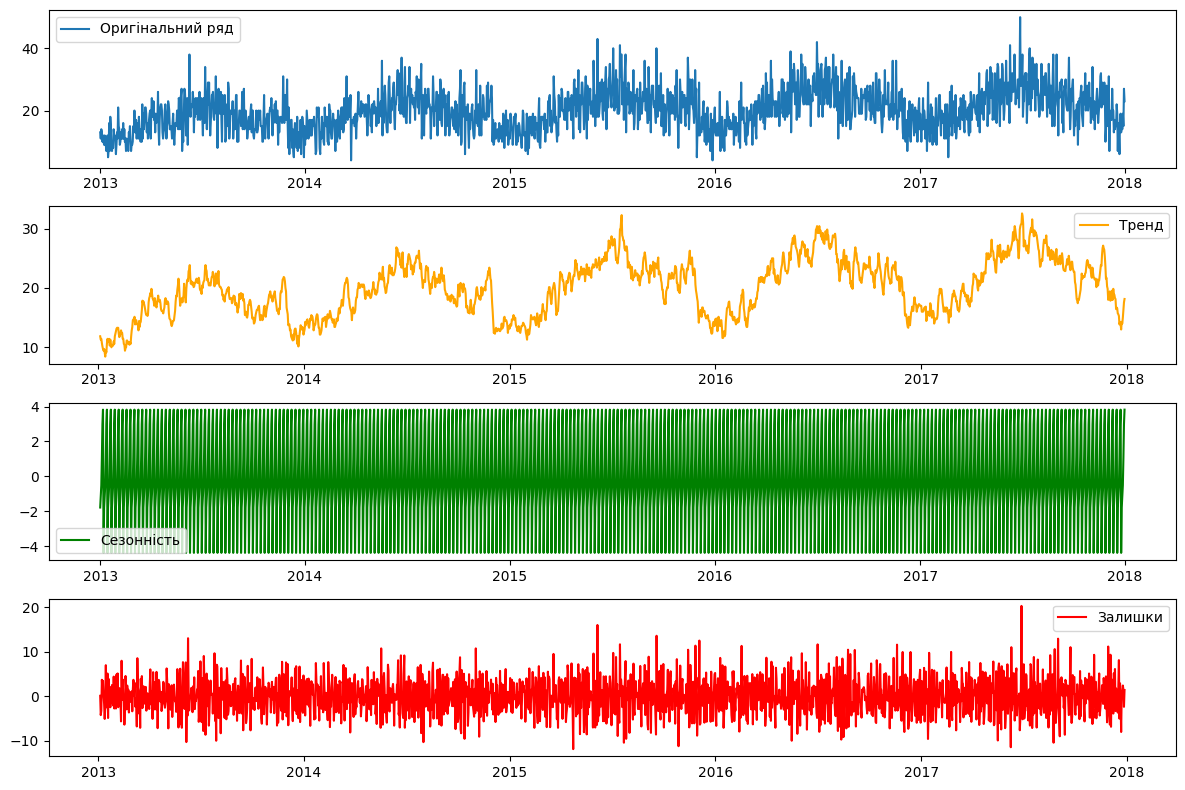

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Вибір підмножини даних для item == 1 та store == 1
subset_df = df[(df["item"] == 1) & (df["store"] == 1)][["sales"]].copy()

# Заповнення пропущених значень (якщо є) методом лінійної інтерполяції
subset_df = subset_df.assign(sales=subset_df["sales"].interpolate(method='linear'))

# Виконання декомпозиції ряду
result = seasonal_decompose(subset_df["sales"], model='additive', period=7)

# Візуалізація результатів декомпозиції
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(subset_df["sales"], label='Оригінальний ряд')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Тренд', color='orange')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Сезонність', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Залишки', color='red')
plt.legend()

plt.tight_layout()
plt.show()

##  Висновки
Висновки з отриманих візуалізацій:

	1.	Оригінальний ряд:
	•	Дані мають чітко виражену сезонність та загальний висхідний тренд із певними періодами спаду.
	•	Видно значну варіативність, що може бути викликано як внутрішніми (маркетингові кампанії, знижки), так і зовнішніми факторами (свята, економічні умови).
	2.	Тренд:
	•	Виявляє загальне зростання продажів із періодичними спадами.
	•	Можливо, є річна сезонність (помітні хвилеподібні коливання кожні 12 місяців).
	•	Важливо підтвердити це статистично або перевірити наявність інших довготривалих циклів.
	3.	Сезонність:
	•	Візуалізація сезонної компоненти виглядає дуже щільною (дуже високочастотні коливання).
	•	Це свідчить про те, що обраний період сезонності (7 днів) може бути замалим, і можливо варто перевірити довші періоди (наприклад, 30 днів або 365 днів).
	•	Також може бути корисним згладжування або групування даних для більшої наочності.
	4.	Залишки:
	•	Досить хаотичні, але спостерігається зміна дисперсії в різні періоди.
	•	Це означає, що модель адитивної декомпозиції може бути не ідеальною, і можливо, варто розглянути мультиплікативну модель.
	•	Є окремі сильні викиди, які варто дослідити окремо (наприклад, перевірити причини різких змін у продажах).

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [18]:
from darts import TimeSeries


# Створення об'єкта TimeSeries в Darts лише для колонки sales
ts_series = TimeSeries.from_dataframe(subset_df, value_cols="sales")


5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

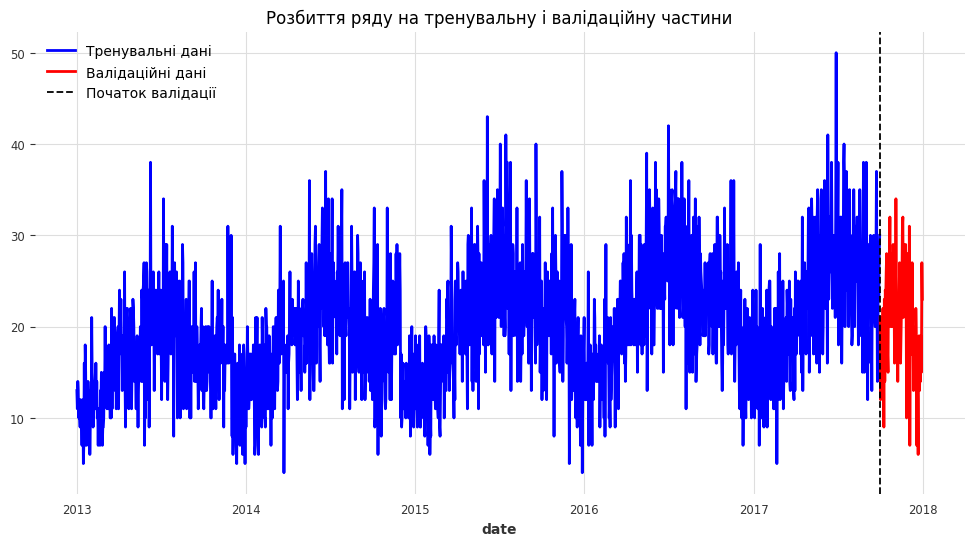

In [19]:

# Розбиття даних на тренувальний і валідаційний набори
train_series, val_series = ts_series.split_before(pd.Timestamp("2017-10-01"))

# Візуалізація тренувальної і валідаційної частини
plt.figure(figsize=(12, 6))
train_series.plot(label="Тренувальні дані", color='blue')
val_series.plot(label="Валідаційні дані", color='red')
plt.axvline(x=pd.Timestamp("2017-10-01"), color='black', linestyle='--', label="Початок валідації")
plt.title("Розбиття ряду на тренувальну і валідаційну частини")
plt.legend()
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 1000x500 with 0 Axes>

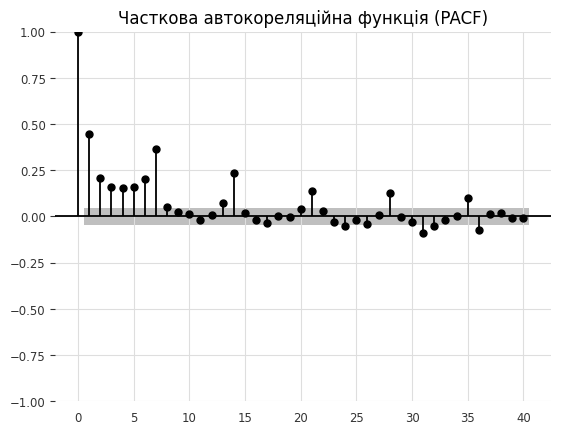

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf

# Побудова часткової автокореляційної функції (PACF)
plt.figure(figsize=(10, 5))
plot_pacf(subset_df["sales"], lags=40, method='ywm', title="Часткова автокореляційна функція (PACF)")
plt.show()

## Висновки з часткової автокореляційної функції (PACF):
	1.	Значущі лаги:
	•	Найсильніша часткова автокореляція спостерігається на лазі 1 – це очікувано, оскільки більшість часових рядів мають сильний зв’язок із попереднім значенням.
	•	Також помітні значущі лаги на 3, 6, 7, 14 – це може вказувати на тижневу або двотижневу сезонність.
	•	Лаги 10, 15 мають вищі значення, що може означати потенційні довготриваліші взаємозв’язки.
    

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [22]:
from darts.utils.statistics import check_seasonality

# Виявлення сезонності тренувального ряду
seasonality_detected, best_period = check_seasonality(train_series, max_lag=365)
print(f"Виявлена сезонність: {seasonality_detected}, Оптимальний період: {best_period}")


Виявлена сезонність: True, Оптимальний період: 7


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

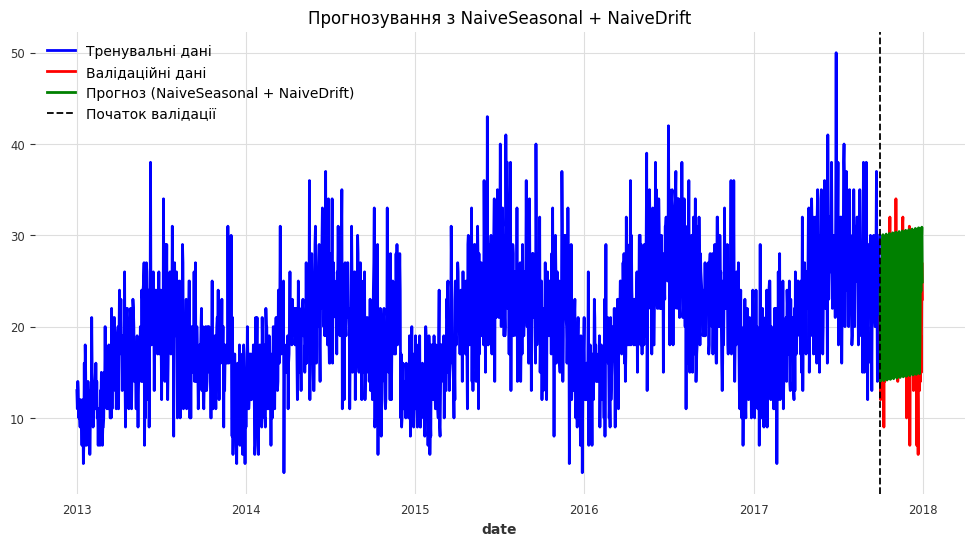

In [29]:
from darts.models import NaiveSeasonal, NaiveDrift

# Побудова наївної моделі NaiveSeasonal + NaiveDrift
naive_seasonal = NaiveSeasonal(K=best_period)
naive_drift = NaiveDrift()

# Навчання моделей
naive_seasonal.fit(train_series)
naive_drift.fit(train_series)

# Прогноз на 92 днів
forecast_seasonal = naive_seasonal.predict(92)
forecast_drift = naive_drift.predict(92)
forecast_combined = forecast_seasonal + forecast_drift - train_series.last_value()

# Візуалізація прогнозів
plt.figure(figsize=(12, 6))
train_series.plot(label="Тренувальні дані", color='blue')
val_series.plot(label="Валідаційні дані", color='red')
forecast_combined.plot(label="Прогноз (NaiveSeasonal + NaiveDrift)", color='green')
plt.axvline(x=pd.Timestamp("2017-10-01"), color='black', linestyle='--', label="Початок валідації")
plt.title("Прогнозування з NaiveSeasonal + NaiveDrift")
plt.legend()
plt.show()

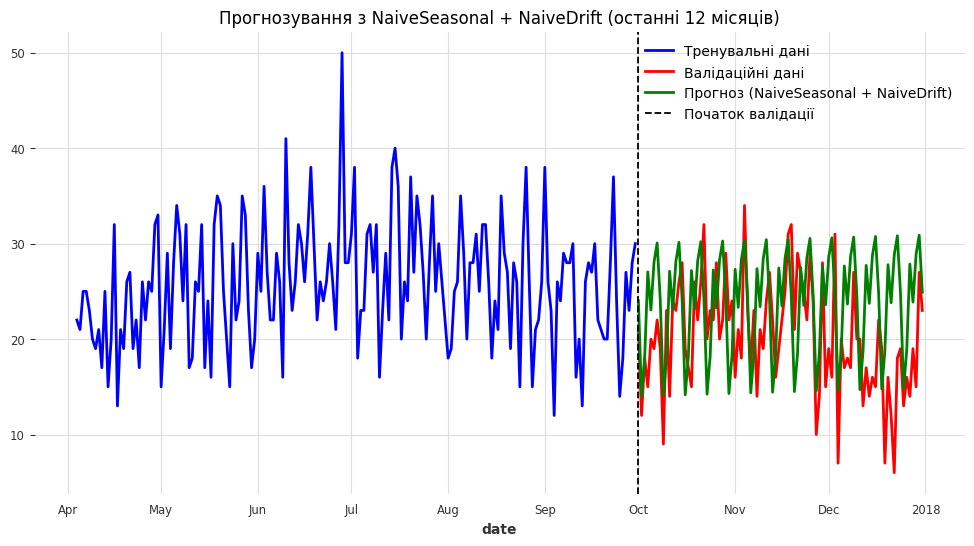

In [31]:
# Візуалізація прогнозів (останні 6 місяців)
plt.figure(figsize=(12, 6))
train_series[-180:].plot(label="Тренувальні дані", color='blue')
val_series.plot(label="Валідаційні дані", color='red')
forecast_combined.plot(label="Прогноз (NaiveSeasonal + NaiveDrift)", color='green')
plt.axvline(x=pd.Timestamp("2017-10-01"), color='black', linestyle='--', label="Початок валідації")
plt.title("Прогнозування з NaiveSeasonal + NaiveDrift (останні 12 місяців)")
plt.legend()
plt.show()

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [33]:
from darts.metrics import mape

# Обчислення помилки прогнозу (MAPE)
mape_error = mape(val_series, forecast_combined)
print(f"MAPE на валідації для NaiveSeasonal + NaiveDrift: {mape_error:.2f}%")


MAPE на валідації для NaiveSeasonal + NaiveDrift: 39.91%


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

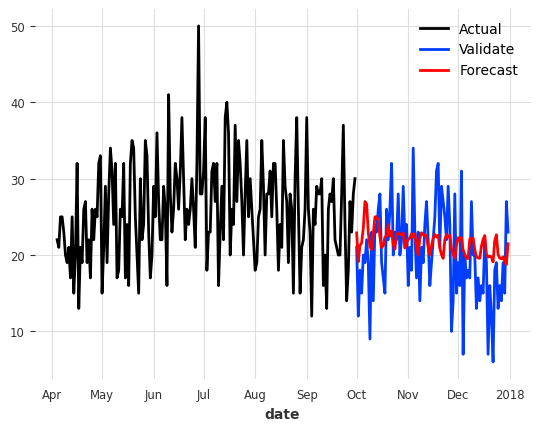

In [41]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

def enrich_with_date_features(df):
  # Feature Extraction
  # df["hour"] = df['Month'].dt.hour
  # df["dayofweek"] = df['Month'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  # df["month"] = df['Month'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  # df["dayofmonth"] = df['Month'].dt.day
  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(train_series.to_dataframe().reset_index())
val_transformed = enrich_with_date_features(val_series.to_dataframe().reset_index())

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(train_series)
test_transformed = scaler.transform(val_series)

# Побудова моделі XGBoost
model = XGBModel(
    lags=12,  # Використання останніх 12 спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=100,  # Кількість дерев у моделі
    max_depth=3,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

# Тренування моделі
model.fit(train_transformed)
pred = model.predict(len(val_series))
pred.values()

scaler.inverse_transform(pred)

forecast = scaler.inverse_transform(model.predict(len(val_series)))
train_series[-180:].plot(label='Actual')
val_series.plot(label='Validate')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

## Висновок

	1.	Тренд та рівень прогнозу
	•	Червона лінія (прогноз) має відносно стабільний рівень без значних коливань.
	•	Візуально здається, що прогноз досить згладжений порівняно з фактичними значеннями.
	2.	Відповідність фактичним даним
	•	Синя лінія (валідовані дані) має значно більші флуктуації, ніж прогноз.
	•	Прогнозована лінія не відображає високої варіативності валідаційних даних, що може свідчити про те, що модель не враховує сезонність або короткострокові коливання.
	3.	Можливі проблеми
	•	Прогноз виглядає надто згладженим і може бути недостатньо точним для врахування коливань у валідаційних даних.
	•	Якщо метою прогнозу було передбачити середнє значення, то він може бути прийнятним. Однак, якщо потрібно враховувати короткострокові зміни, варто покращити модель.


11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [42]:
from darts.models import ExponentialSmoothing

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

def fit_eval_model(model):
    model.fit(train_series)
    forecast = model.predict(len(val_series))
    eval_forecast(model, val_series, forecast)


fit_eval_model(ExponentialSmoothing())

model ExponentialSmoothing() obtains MAPE: 38.94%


## Висновок
    Судячи з MAPE: 38.94% модель трішки краще за  NaiveSeasonal + NaiveDrift

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/Users/luzan/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/luzan/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/luzan/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


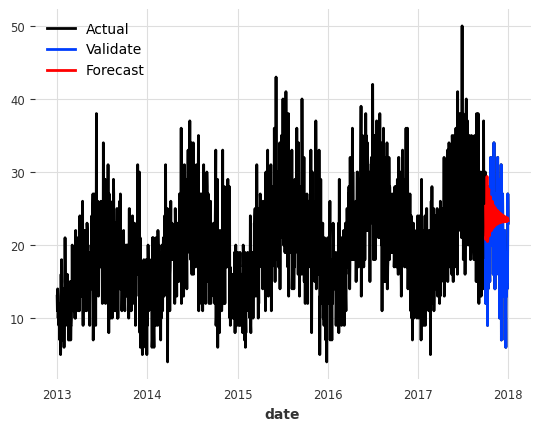

model ARIMA(p=20, d=2, q=3) obtains MAPE: 36.77%


In [53]:
from darts.models import ARIMA

def plot_results(train, val, forecast):
  # Візуалізація результатів
  train.plot(label='Actual')
  val.plot(label='Validate')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, val, forecast)
  eval_forecast(model, val, forecast);


# Побудова та тренування моделі ARIMA
model = ARIMA(p=20, d=2, q=3) # try p=12
fit_and_plot(model, ts_series, train_series, val_series)

## Висновок 
•	Червона лінія (прогноз) має відносно стабільний рівень без значних коливань.
•	Візуально здається, що прогноз досить згладжений порівняно з фактичними значеннями
    Синя лінія (валідовані дані) має значно більші флуктуації, ніж прогноз.
•	Прогнозована лінія не відображає високої варіативності валідаційних даних, що може свідчити про те, що модель не враховує сезонність або короткострокові коливання.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

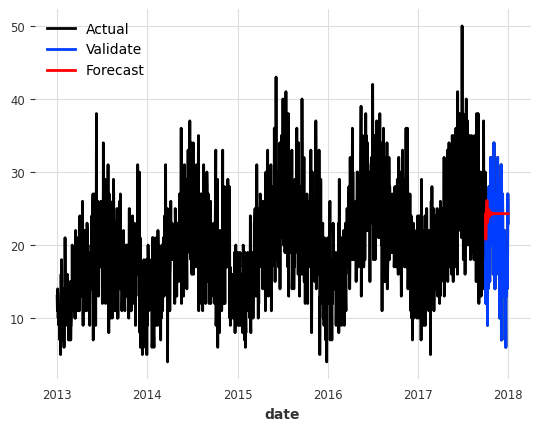

model AutoARIMA(start_p=8, max_p=12, start_q=1) obtains MAPE: 39.53%


In [56]:
import warnings
warnings.filterwarnings("ignore")

from darts.models import AutoARIMA

# Побудова та тренування моделі ARIMA
model = AutoARIMA(start_p=8, max_p=12, start_q=1) # try p=12
fit_and_plot(model, ts_series, train_series, val_series)

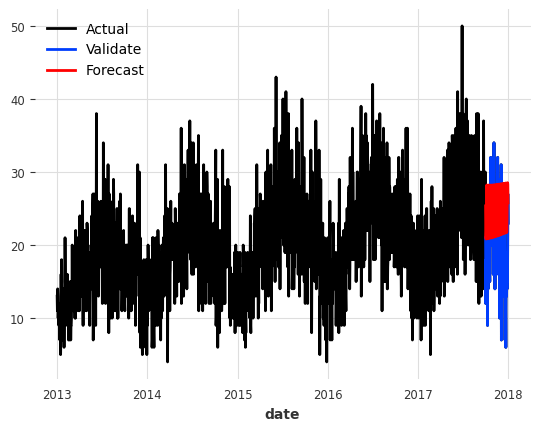

model AutoARIMA() obtains MAPE: 40.70%


In [57]:
model = AutoARIMA() 
fit_and_plot(model, ts_series, train_series, val_series)

## Висновок

 Якість прогнозу не сильно покращилась

14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [69]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable


In [71]:
from darts.models import Prophet

# Побудова та тренування моделі Prophet
model = Prophet()
model.fit(train_series)

# Прогнозування
forecast = model.predict(len(val_series))

# Візуалізація результатів
ts_series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

ImportError: The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


ImportError: The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md

## Висновок
    `Prophet` не захотів становитися на мою локальну машину

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [73]:
from darts.models import RNNModel

train_series = train_series.astype(np.float32)

# Побудова та тренування моделі LSTM
model = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=300)
model.fit(train_series)



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


NameError: name 'мфд_series' is not defined

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

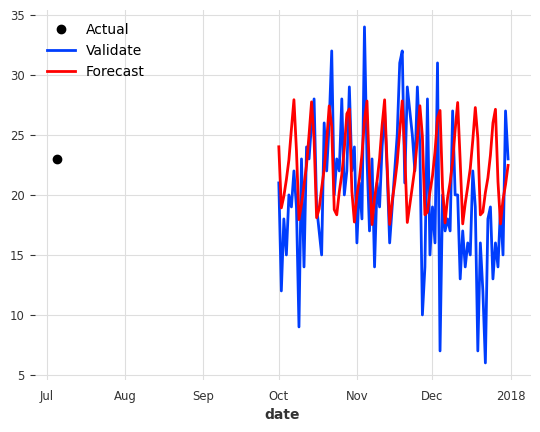

In [82]:
# Прогнозування
forecast = model.predict(len(val_series))

# Візуалізація результатів
ts_series[-180].plot(label='Actual')
val_series.plot(label='Validate')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

##  Висновок 
    Виглядає краще ніж всі попередні

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.